In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from os import environ
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from hydra import compose, initialize
from hydra.utils import instantiate

from bliss.catalog import TileCatalog

In [3]:
# set bliss home directory and load config
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path=".", version_base=None):
    cfg = compose("config")

# Load data

In [4]:
with open("data/synthetic_image.pt", "rb") as f:
    data = torch.load(f)

dataloader = DataLoader(data, batch_size=1, shuffle=False)
batch = next(iter(dataloader))

In [5]:
tile_cat = TileCatalog(4, batch["tile_catalog"])
full_cat = tile_cat.to_full_catalog()

# generate target catalog by restricting to brightest source in tile and filtering by detectable flux
target_cat = tile_cat.get_brightest_source_per_tile()
target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=cfg.encoder.min_flux_threshold)
target_cat = target_cat.to_full_catalog()

# Load Model

In [6]:
model = instantiate(cfg.encoder)
model.load_state_dict(torch.load("/data/scratch/aakash/models/multi_source/single_band_filtered_flux.pt"))
model.eval();


                 from  n    params  module                                  arguments                     
  0                -1  1      3328  yolov5.models.common.Conv               [2, 64, 5, 1]                 
  1                -1  3     12672  yolov5.models.common.Conv               [64, 64, 1, 1]                
  2                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
  3                -1  1    147712  yolov5.models.common.Conv               [128, 128, 3, 1]              
  4                -1  1    295424  yolov5.models.common.Conv               [128, 256, 3, 2]              
  5                -1  6   1118208  yolov5.models.common.C3                 [256, 256, 6]                 
  6                -1  1   1180672  yolov5.models.common.Conv               [256, 512, 3, 2]              
  7                -1  9   6433792  yolov5.models.common.C3                 [512, 512, 9]                 
  8                -1  1   4720640  

In [7]:
# make predictions on batch
results = model.predict_step(batch, None, None)

# Plot Results

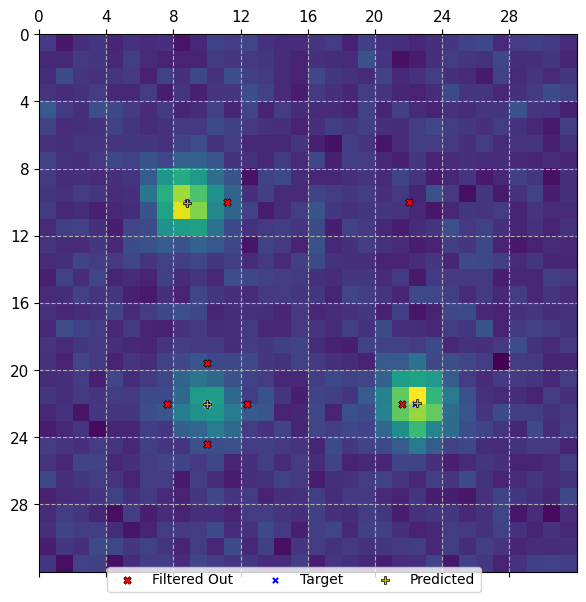

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

# Plot image
image = batch["images"][0, 2]
h, w = image.shape
ax.matshow(image)

# Plot locs
est_cat = results["est_cat"].to_full_params()

full_cat.plot_plocs(ax, 0, "all", c="r", s=30, marker="X", linewidths=0.5, edgecolors="k", label="Filtered Out")
target_cat.plot_plocs(ax, 0, "all", c="b", s=30, marker="X", linewidth=0.5, edgecolors="w", label="Target")
est_cat.plot_plocs(ax, 0, "all", 4, c="y", s=30, marker="P", linewidth=0.5, edgecolors="k", label="Predicted")

# Show grid and legend 
ticks = np.arange(-0.5, h - 0.5, 4)
labels = (ticks + 0.5).astype(int)
ax.set_xticks(ticks, labels)
ax.set_yticks(ticks, labels)
ax.grid(linestyle="--")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0, -0.01, 1, 1), fontsize=10)
fig.tight_layout()